# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

# Load Data

In [ ]:
# Load the dataset
file_path = 'df.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,DATE,COPPER_PRICE,BUY_PRICE,GLOBAL_CONSUMER_PRICE_INDEX,SIX_MONTH_DEMAND,GOLD_PRICE,INVENTORY
0,1/1/2020,3.137096,2.661115,117.999071,30.943593,2345.428509,11.721919
1,2/1/2020,3.080626,2.601521,121.141858,39.010606,2339.954887,34.574074
2,3/1/2020,3.116939,2.596875,122.787487,37.089984,1915.409552,28.794901
3,4/1/2020,3.180225,2.717195,124.483782,39.637642,2119.374158,40.498696
4,5/1/2020,3.220652,2.707316,121.855462,31.061250,2113.274844,34.927412


# Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DATE                         100 non-null    object 
 1   COPPER_PRICE                 100 non-null    float64
 2   BUY_PRICE                    100 non-null    float64
 3   GLOBAL_CONSUMER_PRICE_INDEX  100 non-null    float64
 4   SIX_MONTH_DEMAND             100 non-null    float64
 5   GOLD_PRICE                   100 non-null    float64
 6   INVENTORY                    100 non-null    float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


No missing value

# Data Preprocessing

In [ ]:
# Convert the 'DATE' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set the 'DATE' column as the index of the DataFrame
df.set_index('DATE', inplace=True)

# Round all numerical values in the DataFrame to two decimal places
df = df.round(2)

# Display the first few rows to verify the changes
df.head()

,COPPER_PRICE,BUY_PRICE,GLOBAL_CONSUMER_PRICE_INDEX,SIX_MONTH_DEMAND,GOLD_PRICE,INVENTORY
DATE,,,,,,
2020-01-01,3.14,2.66,118.00,30.94,2345.43,11.72
2020-02-01,3.08,2.60,121.14,39.01,2339.95,34.57
2020-03-01,3.12,2.60,122.79,37.09,1915.41,28.79
2020-04-01,3.18,2.72,124.48,39.64,2119.37,40.50
2020-05-01,3.22,2.71,121.86,31.06,2113.27,34.93


# Correlation Analysis

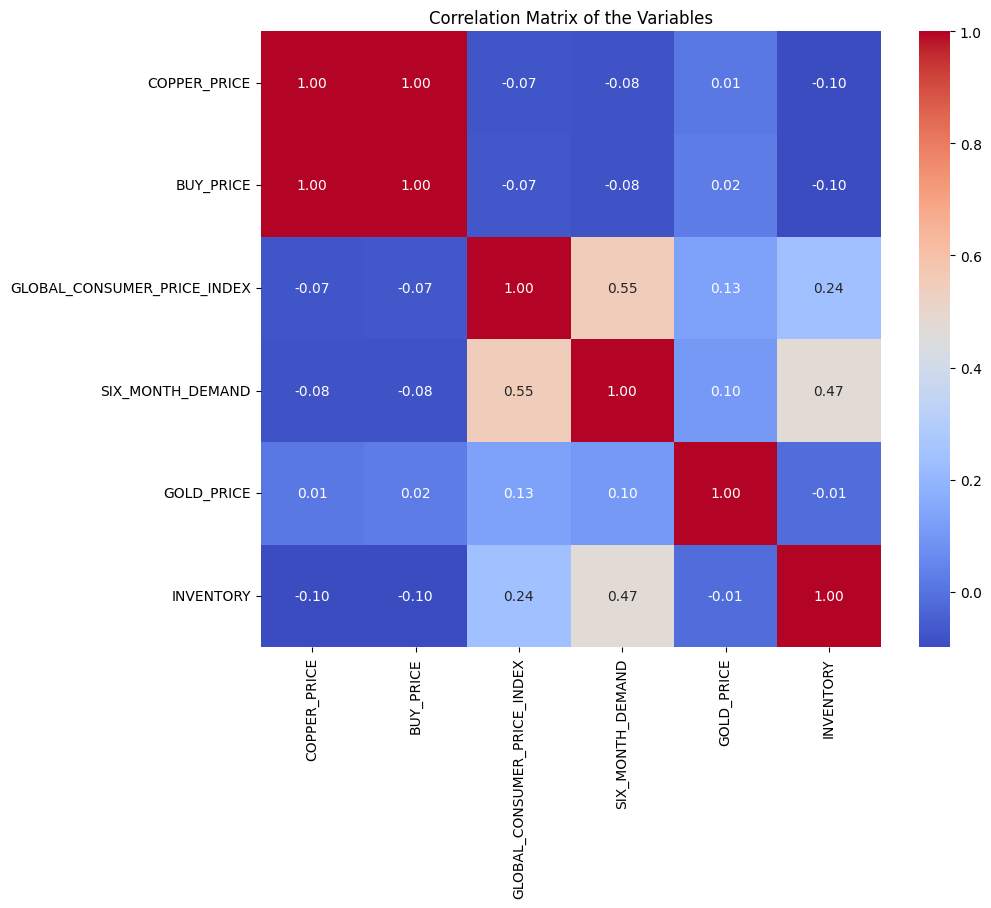

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of the Variables')
plt.show()

In analyzing the correlation matrix, I observed that SIX_MONTH_DEMAND has a relatively strong positive correlation with the GLOBAL_CONSUMER_PRICE_INDEX (around 0.55). This suggests that an increase in the global consumer price index is often associated with an increase in SIX_MONTH_DEMAND. There is also some correlation with INVENTORY levels (around 0.47), although it is weaker. On the other hand, the correlations of SIX_MONTH_DEMAND with copper prices, purchase prices, and gold prices are very low (close to zero), indicating little to no significant linear relationship between these variables and SIX_MONTH_DEMAND.





# Trend Analysis

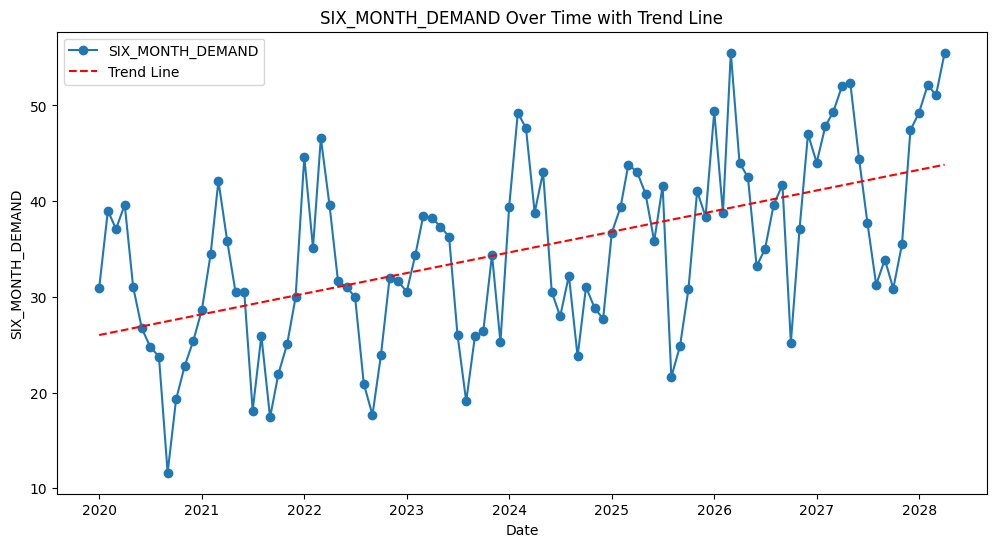

In [ ]:
# Create the plot for SIX_MONTH_DEMAND over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SIX_MONTH_DEMAND'], marker='o', label='SIX_MONTH_DEMAND')

# Fit a linear trend line to the data
z = np.polyfit(df.index.astype('int64') // 10**9, df['SIX_MONTH_DEMAND'], 1)  # Linear fit using integer timestamps
p = np.poly1d(z)
plt.plot(df.index, p(df.index.astype('int64') // 10**9), "r--", label='Trend Line')

# Adding labels and title
plt.title('SIX_MONTH_DEMAND Over Time with Trend Line')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.legend()
plt.show()

The SIX_MONTH_DEMAND plot shows an overall upward trend. Despite significant short-term fluctuations, the trend line (red dashed line) suggests that six-month demand is gradually increasing over the analyzed period. This indicates a tendency toward higher demand over time, which could suggest a growing market or increasing demand for related products/services.

# Seasonality Analysis for 12-Months

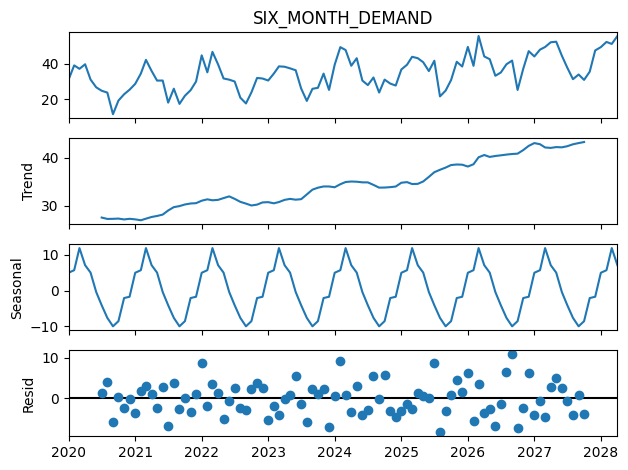

In [ ]:
# Perform seasonal decomposition of the time series
result = seasonal_decompose(df['SIX_MONTH_DEMAND'], model='additive', period=12)
result.plot()
plt.show()

In my analysis of SIX_MONTH_DEMAND, I identified a clear seasonal pattern that recurs annually. This indicates that demand rises and falls in predictable periods, linked to the yearly cycle. This seasonality should be incorporated into predictive models to achieve accurate future forecasts.

The residuals are randomly scattered around zero, indicating that the model has effectively separated the trend and seasonality from the remaining fluctuations. The absence of clear patterns in the residuals suggests that the data does not contain additional regular anomalies or unexpected seasonal effects.

# Seasonality Analysis for 6-Months

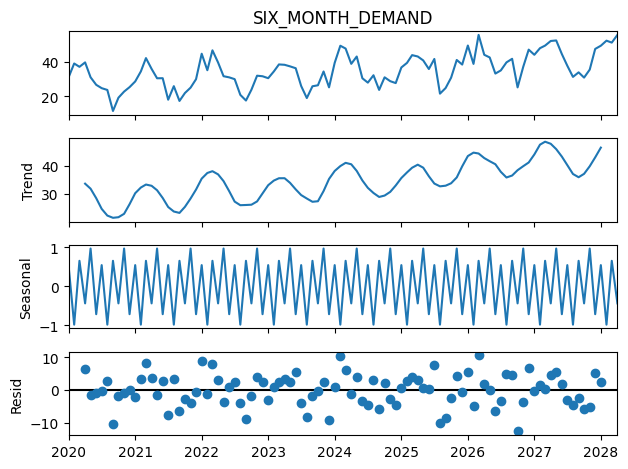

In [ ]:
# Perform seasonal decomposition of the time series
result = seasonal_decompose(df['SIX_MONTH_DEMAND'], model='additive', period=6)
result.plot()
plt.show()

# Split the Data

In [ ]:
# Split the data into training and testing sets using train_test_split
train_data, test_data = train_test_split(df['SIX_MONTH_DEMAND'], test_size=0.2, shuffle=False)

# Plot the entire dataset with train-test split

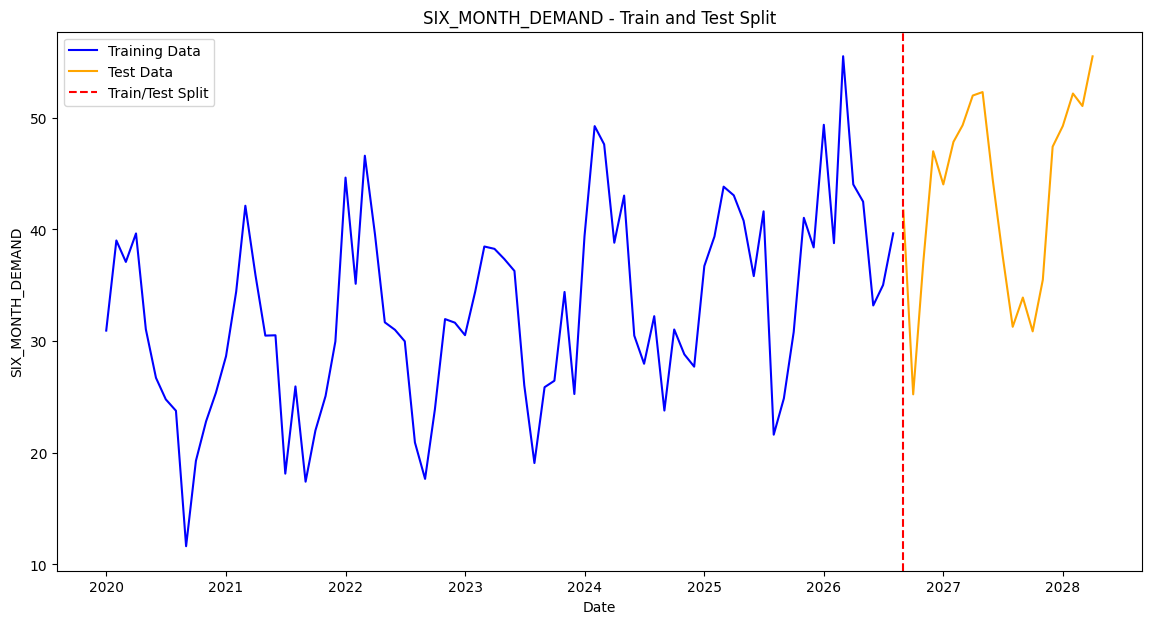

In [ ]:
plt.figure(figsize=(14, 7))

# Plot training data in blue
plt.plot(train_data.index, train_data, label='Training Data', color='blue')

# Plot test data in orange
plt.plot(test_data.index, test_data, label='Test Data', color='orange')

# Adding labels and title
plt.title('SIX_MONTH_DEMAND - Train and Test Split')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.axvline(x=test_data.index[0], color='red', linestyle='--', label='Train/Test Split')  # Line indicating the split point
plt.legend()
plt.show()

# SARIMA Model with 12-Month Seasonality

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=489.415, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=455.024, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=474.129, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=447.311, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=465.738, Time=0.78 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=440.647, Time=1.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=445.538, Time=2.00 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=437.334, Time=2.10 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=442.619, Time=

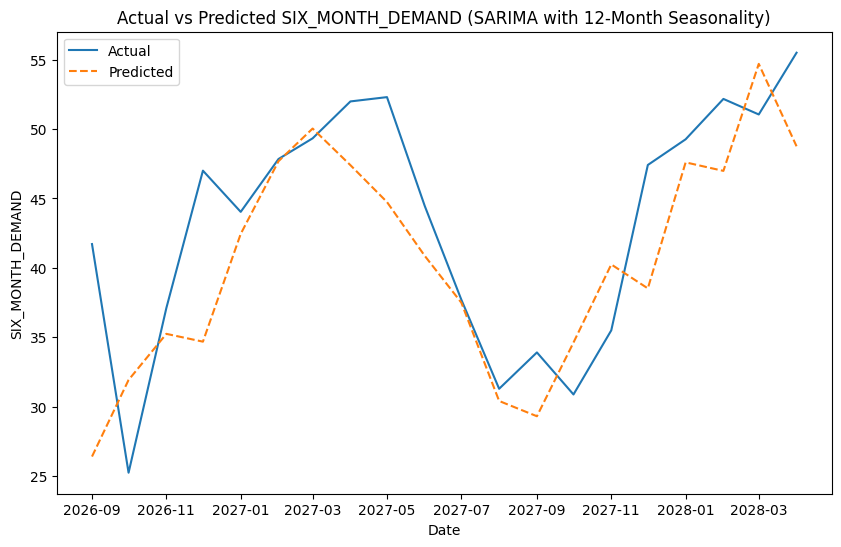

In [ ]:
# Auto-ARIMA to select the best parameters with 12-month seasonality
model_sarima_12 = auto_arima(train_data, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_sarima_12.summary())

# Prediction
predictions_sarima_12 = model_sarima_12.predict(n_periods=len(test_data))
predictions_sarima_12_series = pd.Series(predictions_sarima_12, index=test_data.index)

# Evaluate the model
mse_sarima_12 = mean_squared_error(test_data, predictions_sarima_12_series)
rmse_sarima_12 = np.sqrt(mse_sarima_12)
r2_sarima_12 = r2_score(test_data, predictions_sarima_12_series)

print(f'Mean Squared Error (MSE): {mse_sarima_12}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarima_12}')
print(f'R-squared: {r2_sarima_12}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions_sarima_12_series, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted SIX_MONTH_DEMAND (SARIMA with 12-Month Seasonality)')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.legend()
plt.show()

In my analysis, the SARIMA model achieved an R-squared value of 0.47, meaning that the model explains about 47% of the variance in SIX_MONTH_DEMAND. While this may be less than I anticipated, SARIMA proved to be a better choice compared to a standard ARIMA model because the data exhibits a clear seasonal pattern with a 12-month cycle. This seasonality indicates that demand rises and falls in predictable periods, closely linked to the yearly cycle. It is also worth noting that the dataset is very small, consisting of only 100 records, which is relatively little for machine learning models. Nonetheless, the SARIMA model effectively separated the trend and seasonality from the remaining fluctuations, suggesting that the data does not contain additional regular anomalies. To achieve even better results, I may consider adding more variables or trying other modeling algorithms.

# SARIMA Model with 6-Month Seasonality

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=562.600, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=516.351, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=1.76 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=564.580, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=517.939, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=507.549, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(0,1,2)[6]             : AIC=511.505, Time=0.74 sec
 ARIMA(1,1,0)(2,1,2)[6]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=516.912, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=508.592, Time=0.24 sec
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1

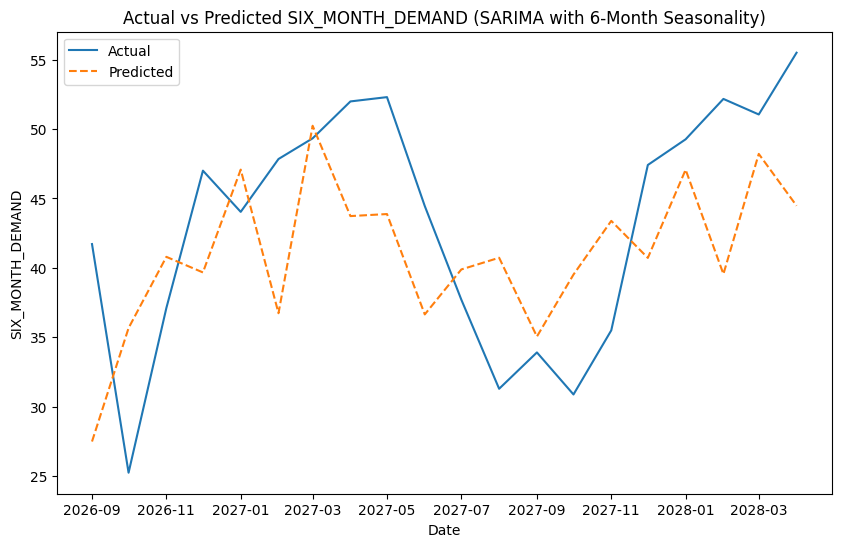

In [ ]:
# Auto-ARIMA to select the best parameters with 6-month seasonality
model_sarima_6 = auto_arima(train_data, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=6,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(model_sarima_6.summary())

# Prediction
predictions_sarima_6 = model_sarima_6.predict(n_periods=len(test_data))
predictions_sarima_6_series = pd.Series(predictions_sarima_6, index=test_data.index)

# Evaluate the model
mse_sarima_6 = mean_squared_error(test_data, predictions_sarima_6_series)
rmse_sarima_6 = np.sqrt(mse_sarima_6)
r2_sarima_6 = r2_score(test_data, predictions_sarima_6_series)

print(f'Mean Squared Error (MSE): {mse_sarima_6}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarima_6}')
print(f'R-squared: {r2_sarima_6}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions_sarima_6_series, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted SIX_MONTH_DEMAND (SARIMA with 6-Month Seasonality)')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.legend()
plt.show()

The XGBoost model with lagging showed a stronger ability to capture demand patterns, although both models left a considerable portion of the variance unexplained.

# XGBoost Model - Training and Evaluation (with laggs)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Mean Squared Error (MSE): 43.67218026753915
Root Mean Squared Error (RMSE): 6.60849304059096
R-squared: 0.413015642345949


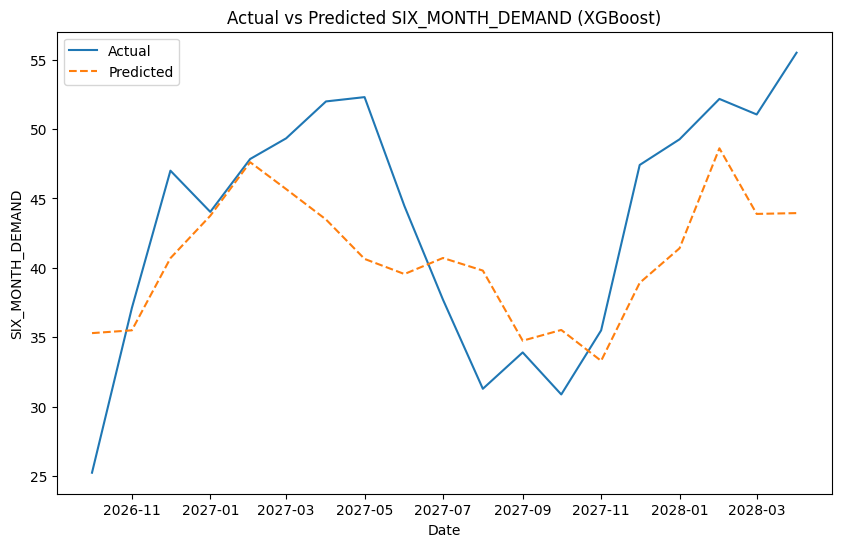

In [ ]:
# Create lagged features
df['SIX_MONTH_DEMAND_LAG1'] = df['SIX_MONTH_DEMAND'].shift(1)
df['SIX_MONTH_DEMAND_LAG2'] = df['SIX_MONTH_DEMAND'].shift(2)
df['SIX_MONTH_DEMAND_LAG3'] = df['SIX_MONTH_DEMAND'].shift(3)
df['SIX_MONTH_DEMAND_LAG4'] = df['SIX_MONTH_DEMAND'].shift(4)

# Create seasonal features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Half_Year'] = df['Month'].apply(lambda x: 1 if x <= 6 else 2)

# Remove rows with missing values due to lagged features
df.dropna(inplace=True)

# Redefine train_size and test_size after dropping rows
train_data, test_data = train_test_split(df['SIX_MONTH_DEMAND'], test_size=0.2, shuffle=False)

# Define target variable (y) and features (X)
y_xgboost = df['SIX_MONTH_DEMAND']
X_xgboost = df[['GLOBAL_CONSUMER_PRICE_INDEX', 'INVENTORY',
                'SIX_MONTH_DEMAND_LAG1', 'SIX_MONTH_DEMAND_LAG2',
                'SIX_MONTH_DEMAND_LAG3', 'SIX_MONTH_DEMAND_LAG4',
                'Year', 'Month', 'Quarter', 'Half_Year']]

# Split the data into training and testing sets
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size=0.2, shuffle=False)

# Add TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'alpha': [0.01, 0.1, 1],
    'lambda': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with time series cross-validation
grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model on the training data
grid_search.fit(X_train_xgboost, y_train_xgboost)

# Best model from GridSearchCV
best_xgboost_model = grid_search.best_estimator_

# Prediction on the test set
predictions_xgboost = best_xgboost_model.predict(X_test_xgboost)

# Evaluate the XGBoost model
mse_xgboost = mean_squared_error(y_test_xgboost, predictions_xgboost)
rmse_xgboost = np.sqrt(mse_xgboost)
r2_xgboost = r2_score(y_test_xgboost, predictions_xgboost)

print(f'Mean Squared Error (MSE): {mse_xgboost}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgboost}')
print(f'R-squared: {r2_xgboost}')

# Plotting the actual vs predicted values for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(y_test_xgboost.index, y_test_xgboost, label='Actual')
plt.plot(y_test_xgboost.index, predictions_xgboost, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted SIX_MONTH_DEMAND (XGBoost)')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.legend()
plt.show()

# XGBoost Model - Training and Evaluation (without laggs)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Mean Squared Error (MSE): 47.89453730054992
Root Mean Squared Error (RMSE): 6.920587930266469
R-squared: 0.35626423869207435


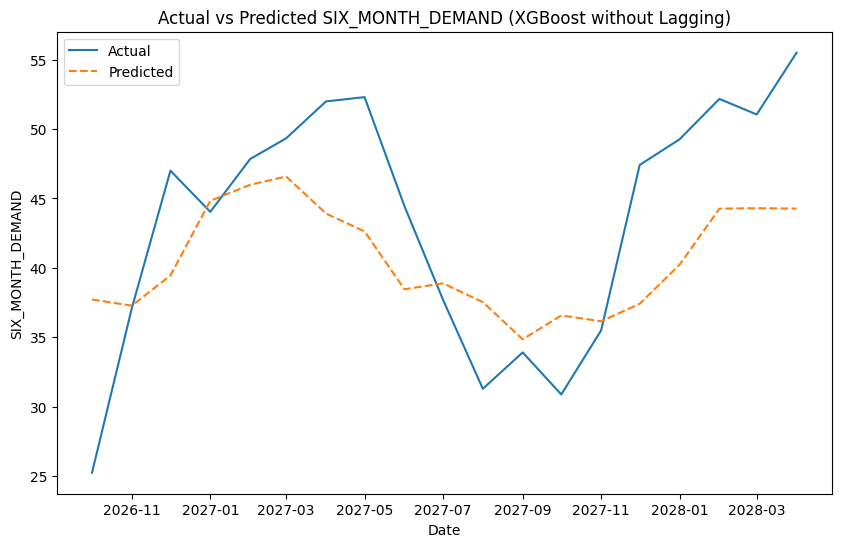

In [ ]:
# Define target variable (y) and features (X) without lagging
y_xgboost_no_lag = df['SIX_MONTH_DEMAND']
X_xgboost_no_lag = df[['GLOBAL_CONSUMER_PRICE_INDEX', 'INVENTORY', 'Year', 'Month', 'Quarter', 'Half_Year']]

# Split the data into training and testing sets
X_train_xgboost_no_lag, X_test_xgboost_no_lag, y_train_xgboost_no_lag, y_test_xgboost_no_lag = train_test_split(X_xgboost_no_lag, y_xgboost_no_lag, test_size=0.2, shuffle=False)

# Add TimeSeriesSplit for cross-validation
tscv_no_lag = TimeSeriesSplit(n_splits=5)

# Define the hyperparameter grid for XGBoost without lagging
param_grid_no_lag = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'alpha': [0.01, 0.1, 1],
    'lambda': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with time series cross-validation
grid_search_no_lag = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid_no_lag, cv=tscv_no_lag, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model on the training data
grid_search_no_lag.fit(X_train_xgboost_no_lag, y_train_xgboost_no_lag)

# Best model from GridSearchCV without lagging
best_xgboost_model_no_lag = grid_search_no_lag.best_estimator_

# Prediction on the test set without lagging
predictions_xgboost_no_lag = best_xgboost_model_no_lag.predict(X_test_xgboost_no_lag)

# Evaluate the XGBoost model without lagging
mse_xgboost_no_lag = mean_squared_error(y_test_xgboost_no_lag, predictions_xgboost_no_lag)
rmse_xgboost_no_lag = np.sqrt(mse_xgboost_no_lag)
r2_xgboost_no_lag = r2_score(y_test_xgboost_no_lag, predictions_xgboost_no_lag)

print(f'Mean Squared Error (MSE): {mse_xgboost_no_lag}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgboost_no_lag}')
print(f'R-squared: {r2_xgboost_no_lag}')

# Plotting the actual vs predicted values for XGBoost without lagging
plt.figure(figsize=(10, 6))
plt.plot(y_test_xgboost_no_lag.index, y_test_xgboost_no_lag, label='Actual')
plt.plot(y_test_xgboost_no_lag.index, predictions_xgboost_no_lag, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted SIX_MONTH_DEMAND (XGBoost without Lagging)')
plt.xlabel('Date')
plt.ylabel('SIX_MONTH_DEMAND')
plt.legend()
plt.show()


# Results

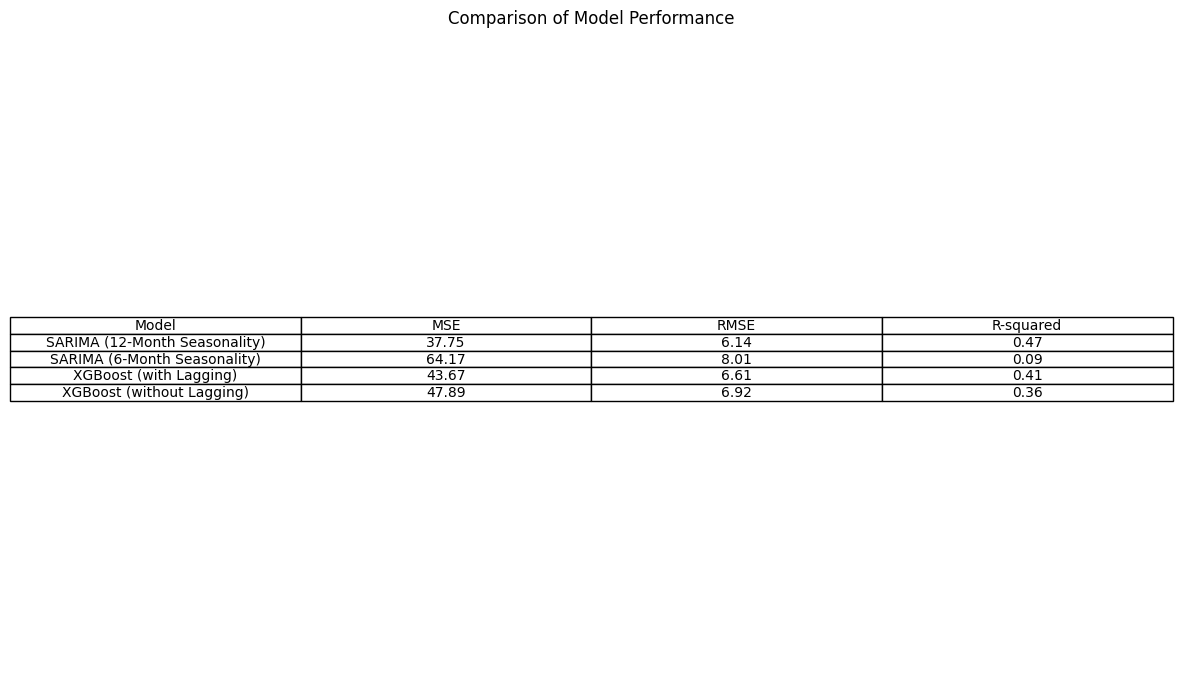

In [ ]:
# Create a dictionary with the results
results = {
    'Model': ['SARIMA (12-Month Seasonality)', 'SARIMA (6-Month Seasonality)', 'XGBoost (with Lagging)', 'XGBoost (without Lagging)'],
    'MSE': [round(mse_sarima_12, 2), round(mse_sarima_6, 2), round(mse_xgboost, 2), round(mse_xgboost_no_lag, 2)],
    'RMSE': [round(rmse_sarima_12, 2), round(rmse_sarima_6, 2), round(rmse_xgboost, 2), round(rmse_xgboost_no_lag, 2)],
    'R-squared': [round(r2_sarima_12, 2), round(r2_sarima_6, 2), round(r2_xgboost, 2), round(r2_xgboost_no_lag, 2)]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
results_df

# Plotting the table as a figure
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')

# Adding title
plt.title('Comparison of Model Performance', pad=20)

plt.show()

The models performance indicates that while there are patterns in the data that these models can capture, there are also significant portions of the variance in SIX_MONTH_DEMAND that remain unexplained. This may be due to the moderate correlations between SIX_MONTH_DEMAND and the input variables, suggesting that other factors not included in the model could be driving demand. Additionally, the relatively small size of the dataset limits the models' ability to generalize and make accurate predictions.

The SARIMA (12-month) model’s performance suggests that seasonality is a crucial component of demand, with annual cycles likely playing a significant role. In contrast, the XGBoost models, while flexible and powerful, appear to require more data or additional features to outperform the SARIMA model in this context.

Future work could focus on gathering more data, exploring additional features, or testing more advanced machine learning models to further improve prediction accuracy.

In [ ]:
!jupyter nbconvert --to html /content/DEMAND_USE_CASE.ipynb

[NbConvertApp] Converting notebook /content/DEMAND_USE_CASE.ipynb to html
[NbConvertApp] Writing 1499152 bytes to /content/DEMAND_USE_CASE.html
